# King County House Sale Project Submission

Please fill out:
* Student name: Linh Mai
* Student pace: self paced 
* Scheduled project review date/time: June 5th, 2020
* Instructor name: Jeff Herman
* Blog post URL: https://linhmai19.github.io/

# Import libraries and the saved dataset

In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
%matplotlib inline 
plt.style.use('seaborn')

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import cross_val_score
import statsmodels.api as sm
from statsmodels.formula.api import ols
import statsmodels.stats.api as sms
import scipy.stats as stats

In [2]:
df = pd.read_csv('cleaned_kc_house_data.csv')
df = df.drop('Unnamed: 0', 1)
df.head()

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,basement,yr_built,zipcode,lat,long,sqft_living15,sqft_lot15
0,2014-10-13,221900.0,3,1.00,1180,5650,1.0,0.0,0.0,3,7,1180,0.0,1955,98178,47.5112,-122.257,1340,5650
1,2014-12-09,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,3,7,2170,1.0,1951,98125,47.7210,-122.319,1690,7639
2,2015-02-25,180000.0,2,1.00,770,10000,1.0,0.0,0.0,3,6,770,0.0,1933,98028,47.7379,-122.233,2720,8062
3,2014-12-09,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,5,7,1050,1.0,1965,98136,47.5208,-122.393,1360,5000
4,2015-02-18,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,3,8,1680,0.0,1987,98074,47.6168,-122.045,1800,7503


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19704 entries, 0 to 19703
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           19704 non-null  object 
 1   price          19704 non-null  float64
 2   bedrooms       19704 non-null  int64  
 3   bathrooms      19704 non-null  float64
 4   sqft_living    19704 non-null  int64  
 5   sqft_lot       19704 non-null  int64  
 6   floors         19704 non-null  float64
 7   waterfront     19704 non-null  float64
 8   view           19704 non-null  float64
 9   condition      19704 non-null  int64  
 10  grade          19704 non-null  int64  
 11  sqft_above     19704 non-null  int64  
 12  basement       19704 non-null  float64
 13  yr_built       19704 non-null  int64  
 14  zipcode        19704 non-null  int64  
 15  lat            19704 non-null  float64
 16  long           19704 non-null  float64
 17  sqft_living15  19704 non-null  int64  
 18  sqft_l

## Further exploration and data cleaning

Check the mean of price based on the number of bedrooms

In [4]:
df.groupby(['bedrooms'])['price'].mean()

bedrooms
1     313389.652632
2     388020.048943
3     431077.318624
4     523458.969920
5     551074.785948
6     560732.697561
7     608828.172414
8     588444.444444
9     670999.750000
10    655000.000000
11    520000.000000
Name: price, dtype: float64

In [5]:
df.groupby(['bedrooms'])['price'].count()

bedrooms
1      190
2     2697
3     9359
4     5984
5     1224
6      205
7       29
8        9
9        4
10       2
11       1
Name: price, dtype: int64

The mean price of the house increases as the number of bedrooms increase. However, when it gets to 8 bedrooms, the mean price starts to fluctuate. Moreover, there are not a lot of houses with 8 or more bedrooms. Therefore, the number of bedrooms is limited to smaller than or equal to 7.

Save this limit to a different dataframe for later regression comparation between keeping the original number of bedrooms and limiting the number of bedrooms to 7.

In [6]:
limit_bedrm = df.copy()
limit_bedrm = df.loc[df['bedrooms'] <= 7, :]

# Explore the relationships between variables

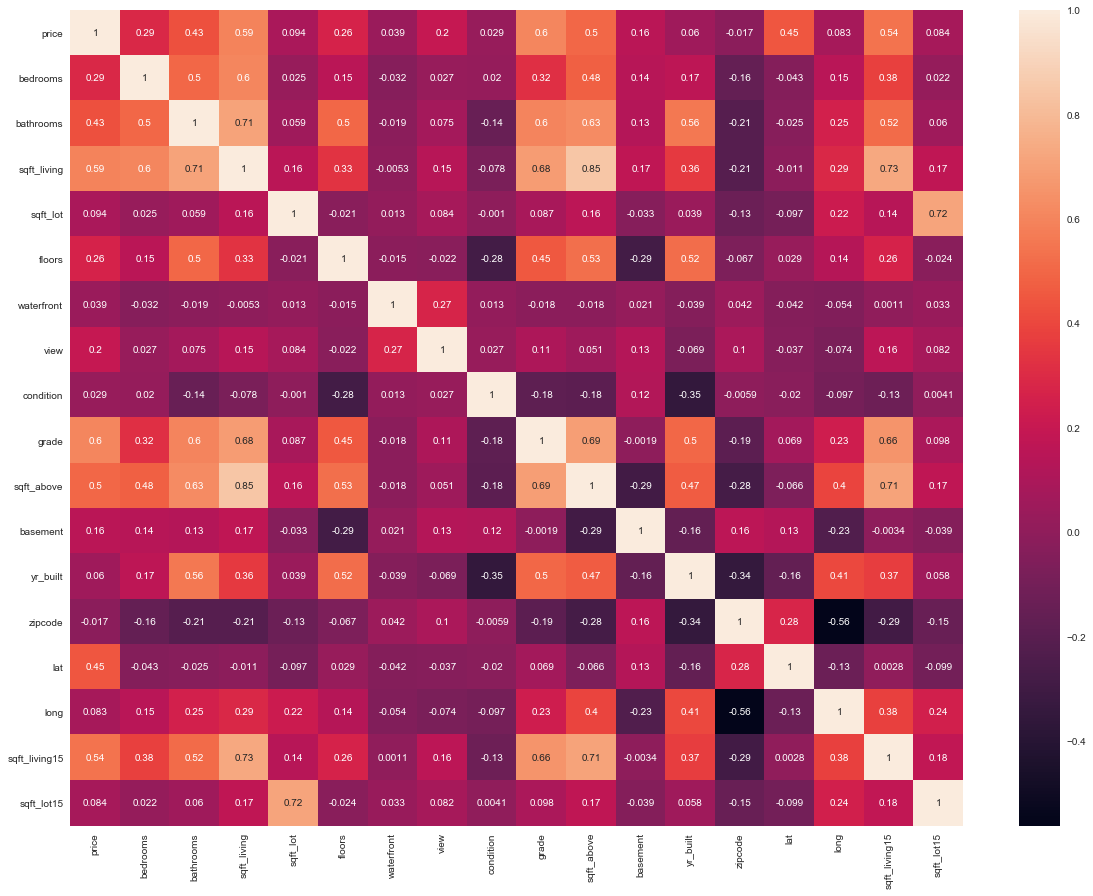

In [7]:
plt.subplots(figsize=(20,15))
sns.heatmap(df.corr(), annot=True)
plt.show()

In [8]:
# Calculate correlation of each feature to price and sort in descending order

corr = df.corr()
corr = corr.stack().reset_index()
corr = corr.rename(columns = {'level_0':'Target', 'level_1':'Features', 0:'Correlation_Values'})
corr = corr.loc[corr['Target'] == 'price']
corr.sort_values(by = 'Correlation_Values', ascending = False)

,Target,Features,Correlation_Values
0,price,price,1.000000
9,price,grade,0.604998
3,price,sqft_living,0.592449
16,price,sqft_living15,0.539434
10,price,sqft_above,0.502177
14,price,lat,0.445195
2,price,bathrooms,0.428647
1,price,bedrooms,0.286811
5,price,floors,0.263328
7,price,view,0.200479


In [9]:
# Calculate correlation between each feature and choose the most highly correlated features
corr = df.corr()
corr = corr.stack().reset_index()
corr = corr.rename(columns = {'level_0':'Feature_1', 'level_1':'Feature_2', 0:'Correlation_Values'})
corr = corr.loc[corr['Feature_1'] != corr['Feature_2']]
corr.loc[corr['Correlation_Values'].abs() > 0.7].sort_values(by = 'Correlation_Values', ascending = False)

,Feature_1,Feature_2,Correlation_Values
64,sqft_living,sqft_above,0.846730
183,sqft_above,sqft_living,0.846730
70,sqft_living,sqft_living15,0.728237
291,sqft_living15,sqft_living,0.728237
89,sqft_lot,sqft_lot15,0.715808
310,sqft_lot15,sqft_lot,0.715808
196,sqft_above,sqft_living15,0.708771
298,sqft_living15,sqft_above,0.708771
39,bathrooms,sqft_living,0.707394
56,sqft_living,bathrooms,0.707394


From the correlation tables above, features that are highly correlated to 'price' are: 
'grade', 'sqft_living', 'sqft_living15', 'sqft_above', 'lat', 'bathrooms', and 'bedrooms'

However, 'sqft_living' is highly correlated to 'sqft_above', 'sqft_living15', and 'bathrooms'. Later, when building a model, 'sqft_living' is not incorporated with those 3 features.  However, other features can be incorporated since they are not highly correlated to each other. 

## Explore the top features

### a) Average price of home based on grade

In [10]:
df.groupby(by = 'grade')['grade'].count().sort_values(ascending = False)

grade
7     8853
8     5789
9     2122
6     1988
10     622
5      234
11      66
4       27
12       2
3        1
Name: grade, dtype: int64

Text(0.5, 1.0, 'Average Price of Home Based on Grade')

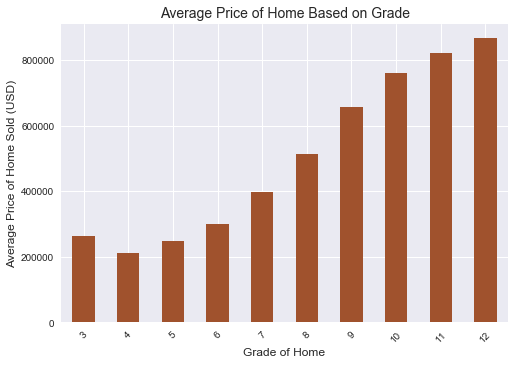

In [11]:
ax = df.groupby(['grade'])['price'].mean().plot(kind = 'bar', color='sienna')
ax.set_xlabel('Grade of Home', fontsize=12)
plt.xticks(rotation=45)
ax.set_ylabel('Average Price of Home Sold (USD)', fontsize=12)
ax.set_title('Average Price of Home Based on Grade', fontsize=14)

### b) Average price of home based on number of bathrooms

Text(0.5, 1.0, 'Average Price of Home Based on Number of Bathrooms')

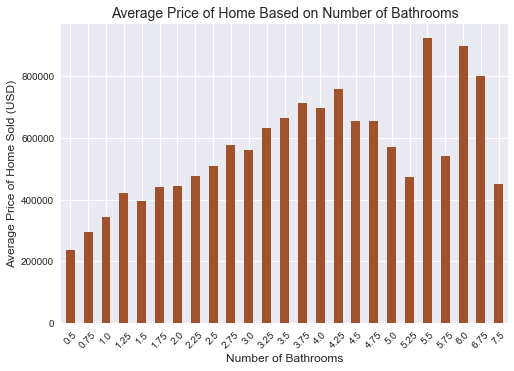

In [12]:
ax = df.groupby(['bathrooms'])['price'].mean().plot(kind = 'bar', color='sienna')
ax.set_xlabel('Number of Bathrooms', fontsize=12)
plt.xticks(rotation=45)
ax.set_ylabel('Average Price of Home Sold (USD)', fontsize=12)
ax.set_title('Average Price of Home Based on Number of Bathrooms', fontsize=14)

### c) Average price of home based on number of bedrooms

Text(0.5, 1.0, 'Average Price of Home Based on Number of Bedrooms')

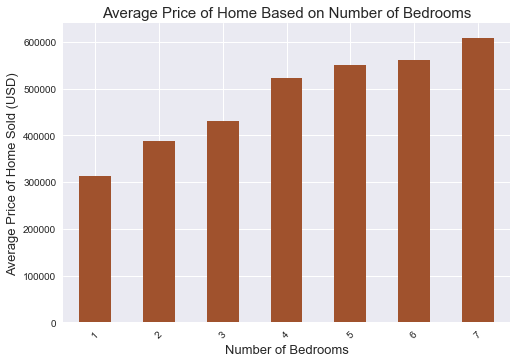

In [13]:
ax = limit_bedrm.groupby(['bedrooms'])['price'].mean().plot(kind = 'bar', color='sienna')
ax.set_xlabel('Number of Bedrooms', fontsize=13)
plt.xticks(rotation=45)
ax.set_ylabel('Average Price of Home Sold (USD)', fontsize=13)
ax.set_title('Average Price of Home Based on Number of Bedrooms', fontsize=15)

### d) Top 20 zipcodes that have most number of homes sold

Text(0.5, 1.0, 'Top 20 Zipcodes with Most Number of Homes Sold')

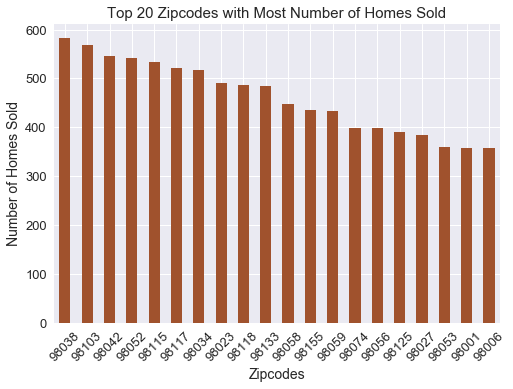

In [14]:
tophomesold = df['zipcode'].value_counts().head(20)
ax = tophomesold.plot(kind = 'bar', x = 'zipcode', y = df['zipcode'].value_counts(), color='sienna')
ax.set_xlabel("Zipcodes", fontsize=14)
ax.tick_params(axis="x", labelsize=13, labelrotation=45)
ax.set_ylabel("Number of Homes Sold", fontsize=14)
ax.tick_params(axis="y", labelsize=13)
ax.set_title("Top 20 Zipcodes with Most Number of Homes Sold", fontsize=15)

### e) Top 20 zipcodes that have the highest home sale prices

Text(0.5, 1.0, 'Top 20 Zipcodes for Home Sale Prices')

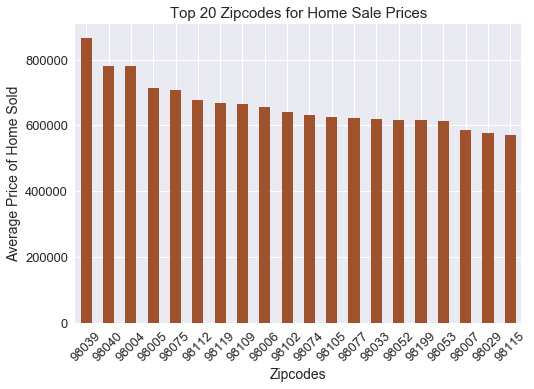

In [15]:
ax = df.groupby(['zipcode'])['price'].mean().sort_values(ascending = False).head(20).plot(kind = 'bar', color='sienna')
ax.set_xlabel("Zipcodes", fontsize = 14)
ax.tick_params(axis="x", labelsize=13, labelrotation=45)
ax.set_ylabel("Average Price of Home Sold", fontsize = 14)
ax.tick_params(axis="y", labelsize=13)
ax.set_title("Top 20 Zipcodes for Home Sale Prices", fontsize = 15)

### f) Home prices based on the locations (given latitude and longitude)

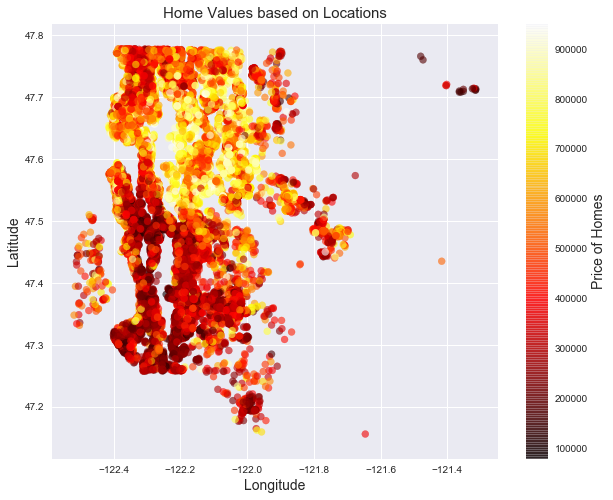

In [16]:
# Using density color bar map to show the home prices based on location  
fig = plt.figure(figsize = (10,8))
plt.scatter(x=df['long'], y=df['lat'], c=df['price'], cmap = 'hot', alpha=0.6)
cbar = plt.colorbar()
cbar.set_label('Price of Homes', fontsize=14)
plt.xlabel('Longitude', fontsize=14)
plt.ylabel('Latitude', fontsize=14)
plt.title('Home Values based on Locations', fontsize=15)
plt.show()

The most expensive houses in King County are located in the northwest of the county. If we compare the colormap above with the real map of King County, these houses are aroung the area of downtown/First Hill, Central Seattle, Capitol Hill/Eastlake. It makes sense that the closer the houses to the capital city Seattle, the higher price of the houses

## KDE plot for checking normality in the target 'price'

'price' is our main target and our goal is to see which predictors work best in predicting out target. Therefore, we first need to check to see whether the target 'price' is close to a normal distribution

In [17]:
df = df.loc[(df['price'] >= 150000)].copy()

Text(0.5, 1.0, 'Distribution of price with KDE plot')

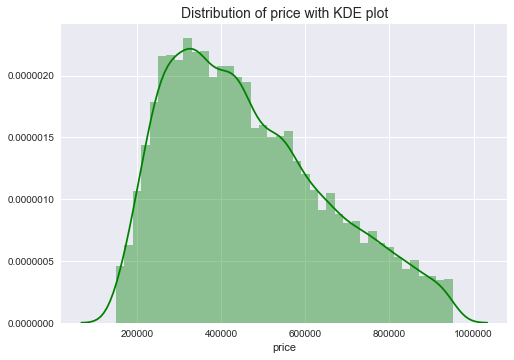

In [18]:
sns.distplot(df['price'], kde=True, color="green")
plt.title('Distribution of price with KDE plot', fontsize=14)

From the KDE plot above, it is clearly not a perfect normal distribution. Therefore, we need to transform it by using log transformation.

Text(0.5, 1.0, 'Distribution of log-transformed price with KDE plot')

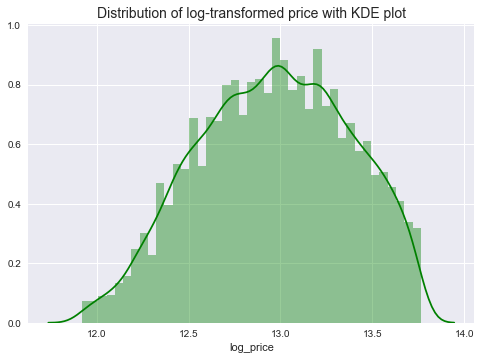

In [19]:
# log transform for 'price'
df['log_price'] = np.log(df['price'])

# Check distribution again with KDE plot
sns.distplot(df['log_price'], kde=True, color="green")
plt.title('Distribution of log-transformed price with KDE plot', fontsize=14)

# Select features with Stepwise selection (by p-values)

In [20]:
outcome = df['log_price']
predictors = df.drop(['log_price', 'price', 'date'], axis=1)

In [21]:
# calculating and displaying each columns p values. The threshold of acceptance is 0.01.
def stepwise_selection(X, y, 
                       initial_list=[], 
                       threshold_in=0.01, 
                       threshold_out = 0.05, 
                       verbose=True):
    """ Perform a forward-backward feature selection 
    based on p-value from statsmodels.api.OLS
    Arguments:
        X - pandas.DataFrame with candidate features
        y - list-like with the target
        initial_list - list of features to start with (column names of X)
        threshold_in - include a feature if its p-value < threshold_in
        threshold_out - exclude a feature if its p-value > threshold_out
        verbose - whether to print the sequence of inclusions and exclusions
    Returns: list of selected features 
    Always set threshold_in < threshold_out to avoid infinite looping.
    See https://en.wikipedia.org/wiki/Stepwise_regression for the details
    """
    included = list(initial_list)
    while True:
        changed=False
        # forward step
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed=True
            if verbose:
                print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))

        # backward step
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.argmax()
            included.remove(worst_feature)
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))
        if not changed:
            break
    return included


result = stepwise_selection(predictors, df['price'], verbose=True)
print('Resulting Features:')
print(result)

Add  grade                          with p-value 0.0
Add  lat                            with p-value 0.0
Add  yr_built                       with p-value 0.0
Add  bathrooms                      with p-value 0.0
Add  sqft_living15                  with p-value 0.0
Add  sqft_living                    with p-value 8.56611e-199
Add  view                           with p-value 2.64636e-98
Add  condition                      with p-value 3.44943e-57
Add  floors                         with p-value 7.58814e-66
Add  sqft_lot                       with p-value 1.18578e-23
Add  zipcode                        with p-value 6.91438e-20
Add  bedrooms                       with p-value 5.95372e-18
Add  waterfront                     with p-value 2.86848e-14
Add  basement                       with p-value 1.69321e-12
Add  sqft_above                     with p-value 1.15666e-13
Add  long                           with p-value 0.00520366
Resulting Features:
['grade', 'lat', 'yr_built', 'bathrooms', 's

# Select features with recursive feature elimination (by weight of the coefficients)

### Min-Max Scaling before RFE

In [22]:
price = df['price']
scaled_price = (price-min(price)) / (max(price)-min(price))
scaled_price_df = df.copy()
scaled_price_df = scaled_price_df.drop(['log_price', 'price', 'date'], axis=1).copy()
scaled_price_df['price'] = scaled_price

### RFE

In [23]:
outcome = scaled_price_df['price']
predictors = scaled_price_df.drop('price', axis=1)

In [24]:
from sklearn.datasets import make_friedman1
from sklearn.feature_selection import RFE

In [25]:
lin_reg = LinearRegression()
selector = RFE(lin_reg, n_features_to_select=5)
selector = selector.fit(predictors, outcome)

In [26]:
#Use boolean mask to pop out names of selected columns
selector.support_ * np.array(predictors.columns)

array(['', '', '', '', '', 'waterfront', 'view', 'condition', 'grade', '',
       '', '', '', 'lat', '', '', ''], dtype=object)

# Calculate OLS regression results through statsmodels

##### 1) Choosing the features based on the stepwise_selection and high correlation with the target

In [27]:
X = df[['grade', 'sqft_living', 'bedrooms']]
X = sm.add_constant(X)
y = df['log_price']

model = sm.OLS(y,X).fit()
predictions = model.predict(X)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.400
Model:                            OLS   Adj. R-squared:                  0.400
Method:                 Least Squares   F-statistic:                     4335.
Date:                Sun, 07 Jun 2020   Prob (F-statistic):               0.00
Time:                        19:46:46   Log-Likelihood:                -5420.0
No. Observations:               19535   AIC:                         1.085e+04
Df Residuals:                   19531   BIC:                         1.088e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          11.5248      0.022    535.397      0.000      11.483      11.567
grade           0.1514      0.003     47.087      0.000       0.145       0.158
sqft_living     0.0002   5.08e-06     38.785      0.000       0.000       0.000
bedrooms       -0.0240      0.003     -7.251      0.000      -0.030      -0.018
==============================================================================
Omnibus:                      277.276   Durbin-Watson:                   1.978
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              163.494
Skew:                          -0.014   Prob(JB):                     3.15e-36
Kurtosis:                       2.553   Cond. No.                     1.99e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.99e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

The R-squared and Adj.R-squared are not high. In addition, the skewness is negative. Therefore, this model is not great. Next, we try other features that are highly correlated with 'price', but we need to drop 'sqft_living' since it is highly correlated to other features (avoid multicollinearity).

##### 2) Not incorparating 'sqft_living'

In [28]:
X = df[['grade', 'lat', 'bathrooms', 'bedrooms']]
X = sm.add_constant(X)
y = df['log_price']

model = sm.OLS(y,X).fit()
predictions = model.predict(X)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.576
Model:                            OLS   Adj. R-squared:                  0.576
Method:                 Least Squares   F-statistic:                     6634.
Date:                Sun, 07 Jun 2020   Prob (F-statistic):               0.00
Time:                        19:46:46   Log-Likelihood:                -2023.1
No. Observations:               19535   AIC:                             4056.
Df Residuals:                   19530   BIC:                             4096.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -53.6873      0.646    -83.110      0.000     -54.953     -52.421
grade          0.1906      0.002     78.119      0.000       0.186       0.195
lat            1.3652      0.014    100.377      0.000       1.339       1.392
bathrooms      0.0747      0.004     19.744      0.000       0.067       0.082
bedrooms       0.0444      0.003     17.574      0.000       0.039       0.049
==============================================================================
Omnibus:                      155.718   Durbin-Watson:                   1.988
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              171.905
Skew:                           0.181   Prob(JB):                     4.69e-38
Kurtosis:                       3.284   Cond. No.                     1.63e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.63e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

R-squared, Adj.R-squared and skewness are clearly improved. We will test again with the number of bedrooms limited to smaller than and equal to 7 to see whether the model is improved.

##### 3) Calculating the OLS regression again with the number of bedrooms limited to smaller than and equal to 7.

In [29]:
limit_bedrm = df.copy()
X = limit_bedrm[['grade', 'lat', 'bathrooms', 'bedrooms']]
X = sm.add_constant(X)
y = limit_bedrm['log_price']

model = sm.OLS(y,X).fit()
predictions = model.predict(X)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.576
Model:                            OLS   Adj. R-squared:                  0.576
Method:                 Least Squares   F-statistic:                     6634.
Date:                Sun, 07 Jun 2020   Prob (F-statistic):               0.00
Time:                        19:46:46   Log-Likelihood:                -2023.1
No. Observations:               19535   AIC:                             4056.
Df Residuals:                   19530   BIC:                             4096.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -53.6873      0.646    -83.110      0.000     -54.953     -52.421
grade          0.1906      0.002     78.119      0.000       0.186       0.195
lat            1.3652      0.014    100.377      0.000       1.339       1.392
bathrooms      0.0747      0.004     19.744      0.000       0.067       0.082
bedrooms       0.0444      0.003     17.574      0.000       0.039       0.049
==============================================================================
Omnibus:                      155.718   Durbin-Watson:                   1.988
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              171.905
Skew:                           0.181   Prob(JB):                     4.69e-38
Kurtosis:                       3.284   Cond. No.                     1.63e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.63e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Nothing really changes when we limited the number of bedrooms to 7.

##### 4) Calculating OLS regression again without 'bedrooms' . Also, adding the next recommended features from recursive feature elimination: 'condition' and 'waterfront'

In [30]:
X = df[['grade', 'lat', 'bathrooms', 'condition', 'waterfront']]
X = sm.add_constant(X)
y = df['log_price']

model = sm.OLS(y,X).fit()
predictions = model.predict(X)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.594
Model:                            OLS   Adj. R-squared:                  0.594
Method:                 Least Squares   F-statistic:                     5713.
Date:                Sun, 07 Jun 2020   Prob (F-statistic):               0.00
Time:                        19:46:46   Log-Likelihood:                -1602.3
No. Observations:               19535   AIC:                             3217.
Df Residuals:                   19529   BIC:                             3264.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -54.2117      0.632    -85.718      0.000     -55.451     -52.972
grade          0.2013      0.002     83.627      0.000       0.197       0.206
lat            1.3696      0.013    102.873      0.000       1.343       1.396
bathrooms      0.1072      0.003     31.614      0.000       0.101       0.114
condition      0.0924      0.003     30.962      0.000       0.087       0.098
waterfront     0.5900      0.040     14.695      0.000       0.511       0.669
==============================================================================
Omnibus:                      119.984   Durbin-Watson:                   1.992
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              133.414
Skew:                           0.151   Prob(JB):                     1.07e-29
Kurtosis:                       3.270   Cond. No.                     1.63e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.63e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

##### R-squared, Adj.R-squared are highest (0.604), compared to other 3 models. 

##### The skewness is also the lowest or nearest to 0 (0.065) which indicates the normally-distributed errors being symmetrically distributed about the mean. 

##### Kurtosis value is also closest to 3 (3.482)which indicates its closeness to normal distribution

##### 5) Model based on RFE with min-max scaling before hand

In [31]:
X = df[['grade', 'lat', 'view', 'condition', 'waterfront']]
X = sm.add_constant(X)
y = df['log_price']

model = sm.OLS(y,X).fit()
predictions = model.predict(X)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.589
Model:                            OLS   Adj. R-squared:                  0.589
Method:                 Least Squares   F-statistic:                     5606.
Date:                Sun, 07 Jun 2020   Prob (F-statistic):               0.00
Time:                        19:46:46   Log-Likelihood:                -1711.6
No. Observations:               19535   AIC:                             3435.
Df Residuals:                   19529   BIC:                             3482.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -53.1002      0.634    -83.746      0.000     -54.343     -51.857
grade          0.2391      0.002    121.012      0.000       0.235       0.243
lat            1.3452      0.013    100.814      0.000       1.319       1.371
view           0.0904      0.003     27.767      0.000       0.084       0.097
condition      0.0840      0.003     28.007      0.000       0.078       0.090
waterfront     0.2554      0.042      6.089      0.000       0.173       0.338
==============================================================================
Omnibus:                       35.582   Durbin-Watson:                   1.997
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               42.110
Skew:                           0.037   Prob(JB):                     7.18e-10
Kurtosis:                       3.215   Cond. No.                     1.62e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.62e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

# Normality check with Q-Q plot

Q-Q plot is used to compare error residuals against a standard normal distribution

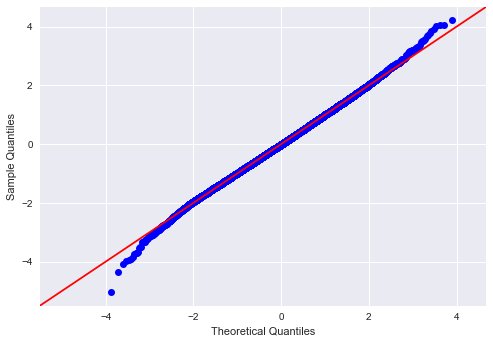

In [32]:
residuals = model.resid
fig = sm.graphics.qqplot(residuals, dist=stats.norm, line='45', fit=True)
fig.show()

## Train-Split test and calculating MSE 

In [33]:
# Split the dataset into training and testing parts
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Checking the length of each data set
print(len(X_train), len(X_test), len(y_train), len(y_test))

15628 3907 15628 3907


In [34]:
# Create an instance of the model
linreg = LinearRegression()

# Fit the model
linreg.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [35]:
# Calculate predictions on training and testing datasets
y_hat_train = linreg.predict(X_train)
y_hat_test = linreg.predict(X_test)

# Calculating MSE by using Scikit-Learn's Mean Squared Error function
train_mse = mean_squared_error(y_train, y_hat_train)
test_mse = mean_squared_error(y_test, y_hat_test)
print('Train Mean Squarred Error:', train_mse)
print('Test Mean Squarred Error:', test_mse)

Train Mean Squarred Error: 0.06932335922254128
Test Mean Squarred Error: 0.07155043038293162


In [36]:
# Calculate the percentage of difference between the train and test MSE
print((train_mse-test_mse)/train_mse)

-0.0321258401982658


In [37]:
# Check R-squared of current test
r_squared = linreg.score(X_test, y_test)
print('R-squared value of current test:', r_squared)

R-squared value of current test: 0.5825850601839361


##### The different between train and test MSE scores is very small. In addtion, R-squared is slightly changed but still above 0.55. It suggests that the model is an appropriate fit.

## K-fold cross validation for mean squared error

Train-test-split models will calculate a slightly different mean squared error each time the model is run due to the random split of train and test data. For this reason, K-fold cross validation is a better method used to validate the multivariate linear regression. K-fold cross validation averages the individual results from multiple linear models which each use a different section of the test data set. K-fold, with 5, 10 and 20 partitions, was used to assess the mean squared error as well as the coefficient of determination for the model

In [38]:
linreg = LinearRegression()

cv_5_results  = -1 * np.mean(cross_val_score(linreg, X, y, cv=5,  scoring='neg_mean_squared_error'))
cv_10_results = -1 * np.mean(cross_val_score(linreg, X, y, cv=10, scoring='neg_mean_squared_error'))
cv_20_results = -1 * np.mean(cross_val_score(linreg, X, y, cv=20, scoring='neg_mean_squared_error'))

cv_5_sci_not = "{:.2e}".format(cv_5_results)
cv_10_sci_not = "{:.2e}".format(cv_10_results)
cv_20_sci_not = "{:.2e}".format(cv_20_results)

print('k fold value of mean squared error, 5 partitions:', cv_5_sci_not)
print('k fold value of mean squared error, 10 partitions:', cv_10_sci_not)
print('k fold value of mean squared error, 20 partitions:', cv_20_sci_not)

k fold value of mean squared error, 5 partitions: 6.99e-02
k fold value of mean squared error, 10 partitions: 6.99e-02
k fold value of mean squared error, 20 partitions: 6.98e-02


## K-fold cross validation for coefficient of determination

In [39]:
linreg = LinearRegression()

cv_5_results  =np.mean(cross_val_score(linreg, X, y, cv=5,  scoring='r2'))
cv_10_results =np.mean(cross_val_score(linreg, X, y, cv=10, scoring='r2'))
cv_20_results =np.mean(cross_val_score(linreg, X, y, cv=20, scoring='r2'))


print('k fold value of coefficient of determination, 5 partitions:', cv_5_results)
print('k fold value of coefficient of determination, 10 partitions:', cv_10_results)
print('k fold value of coefficient of determination, 20 partitions:', cv_20_results)

k fold value of coefficient of determination, 5 partitions: 0.5873121801090402
k fold value of coefficient of determination, 10 partitions: 0.5853259915573228
k fold value of coefficient of determination, 20 partitions: 0.58515184036975


##### The mean squared error came back exactly the same, while the coefficients of determination have very little difference.

The R-squared value, the coefficient of determination, is around 0.60 for this model. This means that 60% of the variations in home prices are explained by the independent variables: 'grade', 'lat', 'bathrooms', 'condition', 'waterfront'. Q-Q plot is used to model error residuals against a standard normal distribution. There are no major deviations from the normal distribution line, proving the earlier assumption of normality.

In order to validate the multivariate linear regression model calculated with statsmodels, train-test-split and cross validation were performed. Train-test- split splits the data into two sections: one serves as the training data set, and the other serves as the testing data set. Each set generates a mean squared error, and the difference between the two will summarize how well the predicted values compare to actual values. 
The train-test-split values calculated for this model had a negligible difference, suggesting the model is an appropriate fit.

However, the train-test-split models calculates a slightly different mean squared error each time the model is run due to the random split of train and test data. For this reason, K-fold cross validation is a better method used to validate the multivariate linear regression. K-fold cross validation averages the individual results from multiple linear models which each use a different section of the test data set. K-fold, with 5, 10 and 20 partitions, was used to assess the mean squared error as well as the coefficient of determination for the model. 
The mean squared error came back exactly the same, while the coefficients of determination have very little difference.


# Check the distribution of model residuals

Text(0.5, 1.0, 'Histogram of Training Set Residuals')

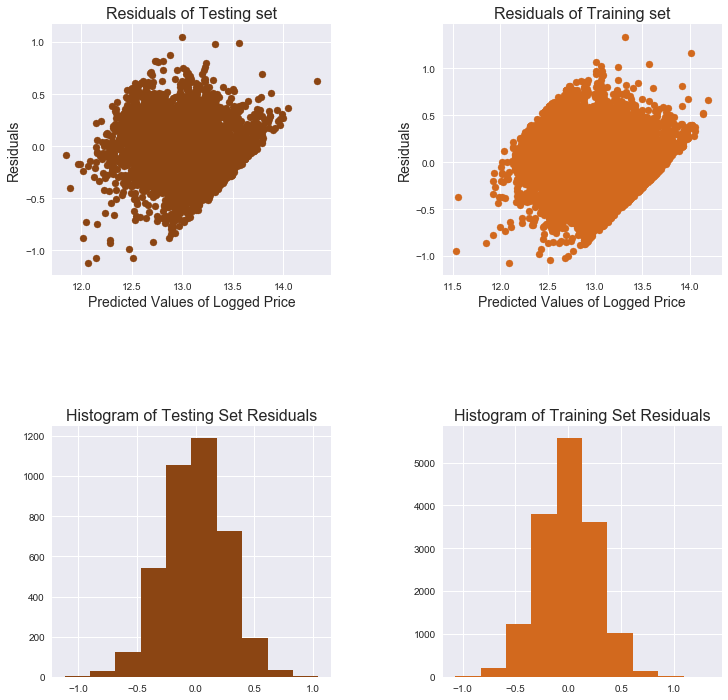

In [40]:
residuals_train = y_hat_train - y_train
residuals_test = y_hat_test - y_test

fig = plt.figure(figsize=(12,12))
plt.subplots_adjust(hspace = 0.6, wspace = 0.4)

ax1 = fig.add_subplot(221)
ax1.scatter(x=y_hat_test, y=residuals_test, c='saddlebrown')
ax1.set_title('Residuals of Testing set', fontsize=16)
ax1.set_xlabel('Predicted Values of Logged Price', fontsize=14)
ax1.set_ylabel('Residuals', fontsize=14)

ax2 = fig.add_subplot(222)
ax2.scatter(x=y_hat_train, y=residuals_train, c='chocolate')
ax2.set_title('Residuals of Training set', fontsize=16)
ax2.set_xlabel('Predicted Values of Logged Price', fontsize=14)
ax2.set_ylabel('Residuals', fontsize=14)

ax3 = fig.add_subplot(223)
ax3.hist(residuals_test, color='saddlebrown') 
ax3.set_title('Histogram of Testing Set Residuals', fontsize=16)

ax4 = fig.add_subplot(224) #Histogram of train residuals
ax4.hist(residuals_train, color='chocolate')
ax4.set_title('Histogram of Training Set Residuals', fontsize=16)

The model residuals are normally distributed 

# The Final Model

Plug all the corresponding coefficients of chosen features ('grade', 'lat', 'bathrooms', 'condition', 'waterfront') and the intercept to express the formula as below

#### ln(price) = grade * (0.207) + latitude * (1.397) + bathrooms * (0.114) + condition * (0.099) + waterfront * (0.602) - 55.58

# Interpret the coefficients

The coefficient of grade is 0.207. This can be interpreted as for one-unit increase in grade, the price of the house will increase by 23% (e**0.207 = 1.23) ((1.23-1) * 100) while keeping the other predictors constant.

The coefficient of the latitude is 1.397. This can be interpreted as for 1 unit increases in latitude, the price of the house will increase by 304% (e**(1.397) = 4.04). 

The coefficient of the bathrooms is 0.114. This can be interpreted as for 1 unit increases in the number of bathrooms, the price of the house will increase by 12% (e**(0.114) = 1.12). 

The coefficient of the condition is 0.099. This can be interpreted as for 1 unit increases in the condition, the price of the house will increase by 10% (e**(0.099) = 1.10). 

The coefficient of the waterfront is 0.602. This can be interpreted as for having a waterfront view, the price of the house will increase by 83% (e**(0.602) = 1.83). 